# Advanced HEPML Tutorial 
**2nd IML Workshop - CERN - Wed. April 11, 2018**

Today you will learn:
* what _jet-images_ are, and how they differ from natural images
* to build and train a Wasserstein-GAN
* to modify the architecture to improve its stability and functionality

Much of today's tutorial is taken from https://github.com/hep-lbdl/adversarial-jets.

<p>In this tutorial, we will be using: <img src="https://cdn-images-1.medium.com/max/1200/1*jcZLpgh3gppeFFgcpFSP0w.jpeg" width="300" align="top">

 > a deep learning framework that puts Python first.

<div align="center">- http://pytorch.org/</div>

Follow the instructions on the [PyTorch website](http://pytorch.org/) to install on your machine.

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
torch.__version__

'0.3.1'

**Dataset**:

We will use the jet-images dataset that our group produced for our LAGAN work [[Comput Softw Big Sci (2017) 1: 4](https://link.springer.com/article/10.1007/s41781-017-0004-6)]:

[![DOI](https://zenodo.org/badge/DOI/10.17632/4r4v785rgx.1.svg)](https://doi.org/10.17632/4r4v785rgx.1)
<a href="https://zenodo.org/record/269622#.WgZFPRNSyRs"><img src="https://github.com/YaleATLAS/CERNDeepLearningTutorial/raw/master/images/zenodo.jpg"></a>

In [339]:
import os
import wget

DATAFILE = 'jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
DATAURL = 'https://zenodo.org/record/269622/files/{}'.format(DATAFILE)

# download dataset unless it's already present
if not os.path.exists(DATAFILE):
    print('Downloading {}'.format(DATAURL))
    wget.download(DATAURL)
else:
    print('Data already exists!')

Data already exists!


Pythia is one of the standard generators used in High Energy Physics to simulate the shower evolution in proton collisions.

**Jets** are the observable result of quarks and gluons scattering at high energy. A collimated stream of
protons and other hadrons forms in the direction of the initiating quark or gluon. Clusters of such
particles are called jets. A **jet image** is a two-dimensional representation of the radiation pattern within
a jet: the distribution of the locations and energies of the jet’s constituent particles.

In this exercise, we won't model the detector response, but we will simply limit ourselves to discretizing the jet energy depositions over a grid of 25x25 cells with side 0.1 in the eta and phi coordinates.

#### Open dataset using `h5py`

In [6]:
import h5py

In [340]:
f = h5py.File(DATAFILE)
list(f.keys())

[u'image',
 u'jet_delta_R',
 u'jet_eta',
 u'jet_mass',
 u'jet_phi',
 u'jet_pt',
 u'signal',
 u'tau_1',
 u'tau_2',
 u'tau_21',
 u'tau_3',
 u'tau_32']

In [392]:
images = f['image'][:10000]

In [393]:
y = f['signal'][:10000]

In [394]:
print(images.shape, y.shape)

((10000, 25, 25), (10000,))


#### Dataset exploration

In [395]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline

In [396]:
def plot_jet_image(content, vmin=1e-20, vmax=300, title=''):
    '''
    Function to help you visualize a jet image on a log scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) --> the average generated image
                       real_images.mean(axis=0) --> the average Pythia image
                       generated_images[aux_out == 1].mean(axis=0) --> the average generated image labeled as real by the discriminator 
                       etc...
       vmin : (default = 1e-6) float, lower bound of the pixel intensity scale before saturation
       vmax : (default = 300) float, upper bound of the pixel intensity scale before saturation
       title : (default = '') string, title of the plot, to be displayed on top of the image
    '''
    fig, ax = plt.subplots(figsize=(7, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    im = ax.imshow(content, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent)
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

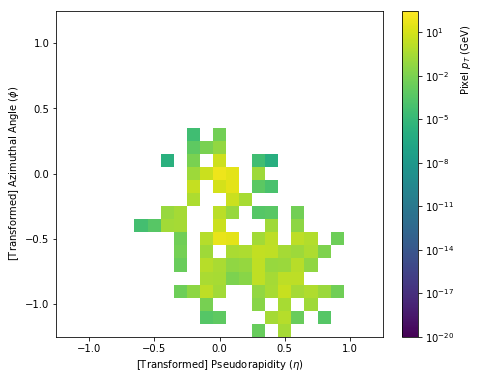

In [397]:
plot_jet_image(images[0])

In [401]:
# plot a bunch of jet images
def plot_random_jetimages(images, njets=6):
    f, axarr = plt.subplots(1, njets, figsize=(15, 5))
    jets = np.random.randint(low=0, high=images.shape[0], size=njets)

    for i, sel in enumerate(jets):
        def _plot_jet(img, vmin=1e-3, vmax=300):
            im = axarr[i].imshow(img,
                                    interpolation='nearest',
                                    norm=LogNorm(vmin=1e-20, vmax=300)
            )
            axarr[i].tick_params(axis='both', which='both', bottom=False, top=False,
                                 left=False, right=False, labelbottom=False,
                                 labelleft=False)
            return im
        im = _plot_jet(images[sel])

    cax = f.add_axes([0.93, 0.3, 0.03, 0.4])
    cb = f.colorbar(im, cax=cax)
    cb.set_label(r'Pixel $p_T$ (GeV)', y=0.85)

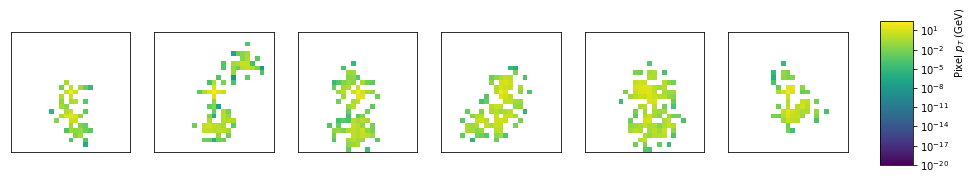

In [402]:
plot_random_jetimages(images)

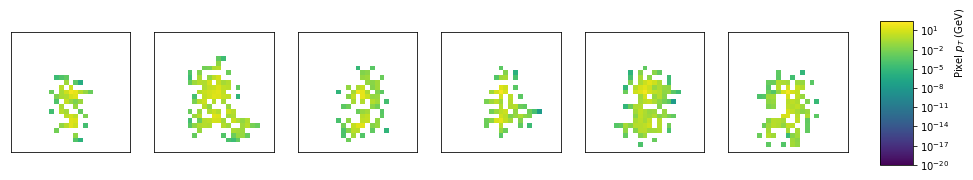

In [403]:
plot_random_jetimages(images)

At an individual level, iet images don't yield themselves to a global understanding of the data distribution. A nice way of visualizing jet images is to investigate the mean jet image.

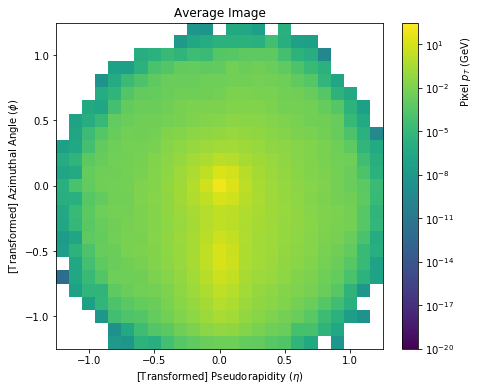

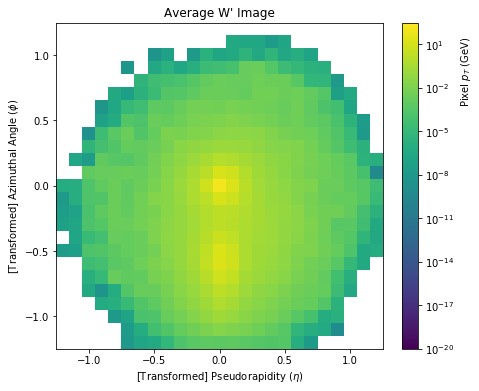

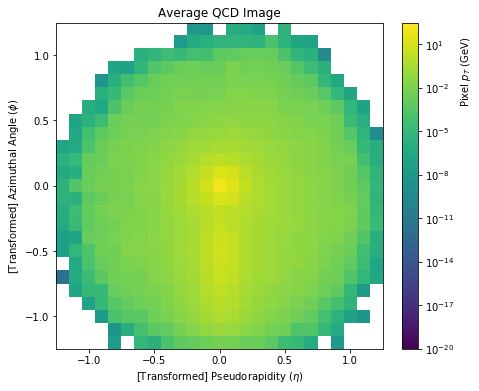

In [404]:
plot_jet_image(np.mean(images, axis=0), title='Average Image')
plot_jet_image(np.mean(images[y == 1], axis=0), title="Average W' Image")
plot_jet_image(np.mean(images[y == 0], axis=0), title="Average QCD Image")

Many differences are imperceptible at this level! Let's dive a bit deeper.

In [405]:
def plot_diff_jet_image(
                    content,
                    extr=None,
                    title='',
                    cmap=matplotlib.cm.PRGn_r):
    '''
    Function to help you visualize the difference between two sets of jet images on a linear scale
    Args:
    -----
       content : numpy array of dimensions 25x25, first arg to imshow, content of the image
                 e.g.: generated_images.mean(axis=0) - real_images.mean(axis=0) --> difference between avg generated and avg Pythia image
                       etc...
       extr : (default = None) float, magnitude of the upper and lower bounds of the pixel intensity scale before saturation (symmetric around 0)
       title : (default = '') string, title of the plot, to be displayed on top of the image
       cmap : (default = matplotlib.cm.PRGn_r) matplotlib colormap, ideally white in the middle
    '''
    fig, ax = plt.subplots(figsize=(6, 6))
    extent=[-1.25, 1.25, -1.25, 1.25]
    if extr == None:
        extr = max( abs(content.min()), abs(content.max()))
    im = ax.imshow(content,
                   interpolation='nearest', norm=Normalize(vmin=-extr, vmax=+extr), extent=extent,
                   cmap=cmap)
    plt.colorbar(im, fraction=0.05, pad=0.05)
    plt.xlabel(r'[Transformed] Pseudorapidity $(\eta)$')
    plt.ylabel(r'[Transformed] Azimuthal Angle $(\phi)$')
    plt.title(title)

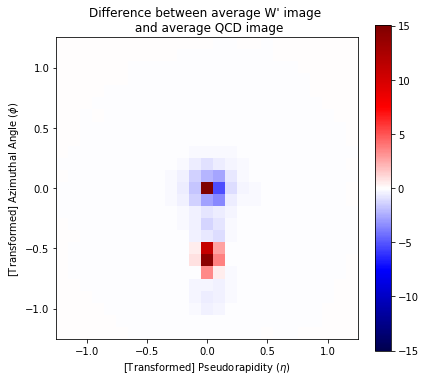

In [406]:
# -- plot the difference between the mean W' image and the mean QCD image
# In this case, the blue pixels are more strongly activated in QCD images than in W' images.
# The red pixels are more strongly activated in W' images than QCD images.
plot_diff_jet_image(
    images[y == 1].mean(axis=0) - images[y == 0].mean(axis=0),
    title="Difference between average W' image \n and average QCD image",
    cmap=matplotlib.cm.seismic
)


#### Domain-specific issues with training GANs for jet images

Most off the shelf GAN implementations will do ok, but some there are some important distinctions between natural images (the domain on which GAN usage exploded) and scientific images such as jet images. Understanding these distinctions can make your models work *significantly* better.

1) Sparsity

We define sparsity (of in this case a matrix $X\in\mathbb{R}^{m \times n}$) to be $$\mathsf{sparsity}(X) = \frac{1}{mn}\sum_{i=1}^{m}\sum_{j=1}^{m} \mathbb{I}_{X_{i, j} \neq 0}$$

Another way to think about this is an "occupancy" rate.

In [407]:
print('Only approximately {:.0f}% of pixels are non zero.'.format(
    100 * float(np.sum(images != 0))/np.prod(images.shape)
))

Only approximately 11% of pixels are non zero.


2) Dynamic range

Images from HEP, due to the nature of the interactions that produce them, vary across **many** orders of magniture, whereas natural images only span three.

In [408]:
print('Pixel intensities range from {:.2e} to {:.2f} GeV.'.format(
    images[images !=0].min(), images.max()
))

Pixel intensities range from 1.34e-20 to 273.79 GeV.


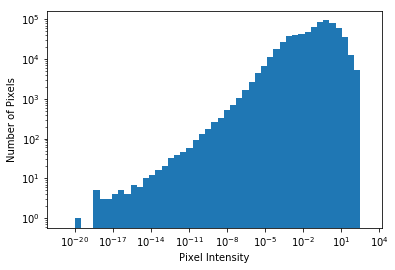

In [409]:
_ = plt.hist(images.ravel(), bins=np.logspace(-21, 3, 50))

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.xscale('log')

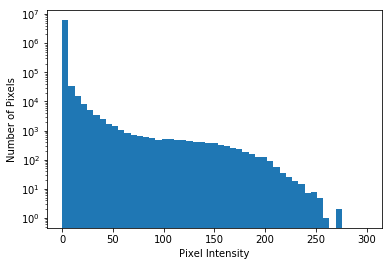

In [410]:
_ = plt.hist(images.ravel(), bins=np.linspace(0, 300, 50))

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')

3) Pixel representation is physically meaningful. Pixel intensities and positions define jet properties.

In this application, we cut out the region of space very close to the beam axis ($\vert\eta\vert \gt 1.25$) and the region of $\vert\phi\vert > 1.25$. We divide the remaining space in a grid with pixels of size $[0.1 \times 0.1]$.

In [411]:
grid = 0.5 * (np.linspace(-1.25, 1.25, 26)[:-1] + np.linspace(-1.25, 1.25, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

We would like to be able to calculate observables from a generated images, so we define discretized versions of $m$, $p_T$, etc.

In [412]:
def discrete_mass(jet_image):
    '''
    Calculates the jet mass from a pixelated jet image set
    Args:
    -----
        jet_image: numpy ndarray of dim (n_images, 25, 25)
    Returns:
    --------
        M: float, jet mass
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(1, 2))
    E = np.sum(jet_image * np.cosh(eta), axis=(1, 2))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    '''
    Calculates the jet transverse momentum from a pixelated jet image set
    Args:
    -----
        jet_image: numpy ndarray of dim (n_images, 25, 25)
    Returns:
    --------
        float, jet transverse momentum
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(1, 2))
    Py = np.sum(jet_image * np.sin(phi), axis=(1, 2))
    return np.sqrt(np.square(Px) + np.square(Py))

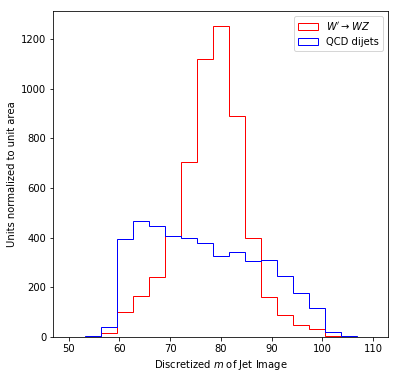

In [413]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(50, 110, 20)
_ = plt.hist(discrete_mass(images[y == 1]), 
             bins=bins, histtype='step', label=r"$W' \rightarrow WZ$", color='red')

_ = plt.hist(discrete_mass(images[y == 0]), 
             bins=bins, histtype='step', label=r'QCD dijets', color='blue')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()

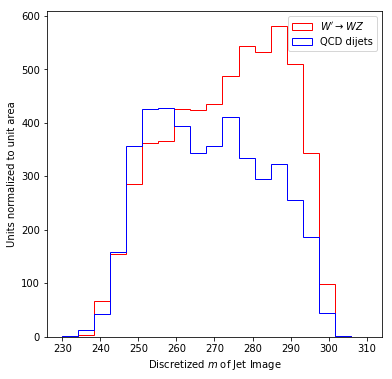

In [414]:
fig, ax = plt.subplots(figsize=(6, 6))
bins = np.linspace(230, 310, 20)
_ = plt.hist(discrete_pt(images[y == 1]), 
             bins=bins, histtype='step', label=r"$W' \rightarrow WZ$", color='red')

_ = plt.hist(discrete_pt(images[y == 0]), 
             bins=bins, histtype='step', label=r'QCD dijets', color='blue')

plt.xlabel(r'Discretized $m$ of Jet Image')
plt.ylabel(r'Units normalized to unit area')
plt.legend()

### PyTorch Dataset and DataLoader

PyTorch takes care of lots of data handling for you through the convenient `DataLoader` class. A `DataLoader` allows you to iterate through your dataset and yield batches from it with a few niceties attached. These may not be necessary in this application, and in fact they might be kind of an overkill, but I think everyone should be familiar with them.

First, you have to create your own custom dataset class that inherits from the abstract PyTorch `Dataset` class. All custom datasets should subclass it, and override `__len__`, that provides the size of the dataset, and `__getitem__`, supporting integer indexing in range from `0` to `len(self)` exclusive.

The beauty of the PyTorch `DataLoader` class is that certain complexities such as batching and multithreaded loading are *abstracted away*.

<img src="/Users/mp744/Documents/MachineLearning/presentations/images/dataloader.jpg">

In [29]:
from torch.utils.data import Dataset, DataLoader

Let's remind ourselves of the keys present in the `h5py` file.

In [343]:
list(f.keys())

[u'image',
 u'jet_delta_R',
 u'jet_eta',
 u'jet_mass',
 u'jet_phi',
 u'jet_pt',
 u'signal',
 u'tau_1',
 u'tau_2',
 u'tau_21',
 u'tau_3',
 u'tau_32']

In [351]:
class JetSet(Dataset):
    """
    Dataset of jet images.
    """
    def __init__(self, zenodo_link=None, path=None, nb_jets=None):
        if not ((zenodo_link is None) ^ (path is None)):
            raise ValueError('Exactly *one* of Zenodo link or '
                             'filesystem path must be specified')
        if zenodo_link is not None:
            # download dataset unless it's already present
            filename = zenodo_link.split("/")[-1]
            if not os.path.exists(filename):
                wget.download(zenodo_link)
        else:
            filename = path
            
        if nb_jets is not None and not isinstance(nb_jets, int):
            raise TypeError('nb_jets must be an int!')
        f = h5py.File(filename)
        
        # load all objects into memory
        self.images = f['image'][:nb_jets]
        self.jet_dr = f['jet_delta_R'][:nb_jets]
        self.jet_eta = f['jet_eta'][:nb_jets]
        self.jet_mass = f['jet_mass'][:nb_jets]
        self.jet_phi = f['jet_phi'][:nb_jets]
        self.jet_pt = f['jet_pt'][:nb_jets]
        self.y = f['signal'][:nb_jets]
        self.tau_21 = f['tau_21'][:nb_jets]
        self.tau_32 = f['tau_32'][:nb_jets]
    
    def __len__(self):
        return self.y.shape[0]
    
    @staticmethod
    def image_transform(image):
        return image / 75.0
    
    @staticmethod
    def inverse_image_transform(image):
        return image * 75.0
    
    
    def __getitem__(self, idx):
#         sample = {
#             'images' : self.images[idx],
#             'jet_dr' : self.jet_dr[idx],
#             'jet_eta' : self.jet_eta[idx],
#             'jet_mass' : self.jet_mass[idx],
#             'jet_phi' : self.jet_phi[idx],
#             'jet_pt' : self.jet_pt[idx],
#             'y' : self.y[idx],
#             'tau_21' : self.tau_21[idx],
#             'tau_32' : self.tau_32[idx]
#         }
#         return sample
        return (self.images[idx], self.y[idx])


In [352]:
dataset = JetSet(DATAURL)#, nb_jets=30000)

In [353]:
BATCH_SIZE = 100
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True,
                                          num_workers=3)

In [354]:
n_batches = int(np.ceil(len(dataset)/ BATCH_SIZE)) 

In [355]:
n_batches

8726

### Model Design

`torch.nn` contains all the ingredients to start building your networks. 

PyTorch is still in beta, so there are no well-defined best practices and lots of ways of doing the same thing, some that are safer and limited in scope, and some that provide you with more flexibility, should you need it.

In [36]:
from torch import nn

`torch.nn.Sequential` is a container that allows you to specify Modules to be added to your model in the order they are passed into the constructor. If you are coming from Keras, this is very similar to a `keras.models.Sequential` object. 

Alternatively, you can also pass layers into the Module as an `OrderedDict`.

In [104]:
# Discriminator
D = nn.Sequential(
    nn.Linear(25 * 25, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [105]:
# Generator 
G = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 25 * 25),
    nn.ReLU()
)

In [96]:
# if you're running on GPU, move models there
# if torch.cuda.is_available():
#     print 'Will run model on the GPU'
#     D.cuda()
#     G.cuda()

Define your loss function and optimizer by picking from the ones already available in `torch.nn` or defining your own. Note that an optimizer is defined in terms of the network parameters that it's assigned to optimize.

In [106]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

### Training Procedure

A `Variable` is a node in a computational graph that allows for automatic differentiation across the graph. A `Variable` wraps a PyTorch `Tensor`, though rumor has it the two concepts will soon be unified. `x.data` gives you access to the `Tensor` wrapped by the `Variable x`.

In [107]:
from torch.autograd import Variable

def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [108]:
import torch.nn.functional as F

PyTorch allows you to build **dynamic graphs** in a very intuitive and pythonic way. 

You should write the training loop yourself, looping through the epochs and the batches.

Although this adds additional boilerplate and room for error when compared to libraries like Keras, this dynamic construction gives the flexibility required for exotic train loops that do not fit the `model.fit(...)` paradigm, such as GANs.

In [116]:
N_EPOCHS = 10
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 

            # Reshape training dataset images from (batch_size, 25, 25) to (batch_size, 25*25) for 
            # processing through fully-connected net 
            batch_size = images.shape[0] # this specific batch size (last one may not be equal to BATCH_SIZE)
            images = to_var(images.view(batch_size, -1))

            # Create targets for the discriminator network D
            # (can use label flipping or label smoothing)
            real_labels = to_var(torch.ones(batch_size, 1)) 
            fake_labels = to_var(torch.zeros(batch_size, 1))

            # 1) TRAIN DISCRIMINATOR
            # Evaluate the discriminator on the real input images
            outputs = D(images) # or D(add_instance_noise(images))
            real_score = outputs
            # Compute the discriminator loss with respect to the real labels (1s)
            d_loss_real = criterion(outputs, real_labels)

            # Draw random 64-dimensional noise vectors as inputs to the generator network
            z = to_var(torch.randn(batch_size, 64)) # the latents space is 64D
            # Transform the noise through the generator network to get synthetic images
            fake_images = G(z)
            # Evaluate the discriminator on the fake images
            outputs = D(fake_images) # or D(add_instance_noise(fake_images))
            fake_score = outputs
            # Compute the discriminator loss with respect to the fake labels (0s)
            d_loss_fake = criterion(outputs, fake_labels)

            # Backprop + Optimize the discriminator
            d_loss = d_loss_real + d_loss_fake
            D.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2) TRAIN GENERATOR
            # Draw random 64-dimensional noise vectors as inputs to the generator network
            z = to_var(torch.randn(batch_size, 64))
            # Transform the noise through the generator network to get synthetic images
            fake_images = G(z)
            # Evaluate the (new) discriminator on the fake images
            outputs = D(fake_images)

            # Compute the cross-entropy loss with "real" as target (1s). This is what the G wants to do
            g_loss = criterion(outputs, real_labels)

            # Backprop + Optimize the generator
            D.zero_grad() # probably unnecessary?
            G.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (batch_number + 1) % 100 == 0:
                print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                      'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                      %(epoch,
                        N_EPOCHS,
                        batch_number + 1,
                        n_batches,
                        d_loss.data[0],
                        g_loss.data[0],
                        real_score.data.mean(),
                        fake_score.data.mean())
                )

        # Save the trained parameters 
        torch.save(G.state_dict(), './weights/generator-%0.3d.pkl' %(epoch + 1))
        torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print('Training ended early.')

Epoch [0/10], Step[100/8726], d_loss: 0.8899, g_loss: 2.1014, Mean D(x): 0.68, Mean D(G(z)): 0.23
Epoch [0/10], Step[200/8726], d_loss: 0.8140, g_loss: 1.7249, Mean D(x): 0.69, Mean D(G(z)): 0.25
Epoch [0/10], Step[300/8726], d_loss: 0.7298, g_loss: 1.6072, Mean D(x): 0.74, Mean D(G(z)): 0.25
Epoch [0/10], Step[400/8726], d_loss: 1.0345, g_loss: 1.7660, Mean D(x): 0.68, Mean D(G(z)): 0.32
Epoch [0/10], Step[500/8726], d_loss: 0.9914, g_loss: 1.6759, Mean D(x): 0.68, Mean D(G(z)): 0.34
Epoch [0/10], Step[600/8726], d_loss: 0.8508, g_loss: 2.0604, Mean D(x): 0.73, Mean D(G(z)): 0.28
Epoch [0/10], Step[700/8726], d_loss: 0.8846, g_loss: 1.6677, Mean D(x): 0.73, Mean D(G(z)): 0.29
Epoch [0/10], Step[800/8726], d_loss: 0.7938, g_loss: 1.8010, Mean D(x): 0.73, Mean D(G(z)): 0.27
Epoch [0/10], Step[900/8726], d_loss: 0.8735, g_loss: 1.9295, Mean D(x): 0.66, Mean D(G(z)): 0.22
Epoch [0/10], Step[1000/8726], d_loss: 0.8275, g_loss: 1.8771, Mean D(x): 0.71, Mean D(G(z)): 0.26
Epoch [0/10], Step[

In [192]:
# reload weights from any epoch
G.load_state_dict(torch.load('weights/generator-001.pkl')) # 009, 020

Check image quality and properties at that epoch:

In [193]:
batch_size = 100
z = to_var(torch.randn(batch_size, 64))
fake_images = G(z).data.numpy().reshape(-1, 25, 25)

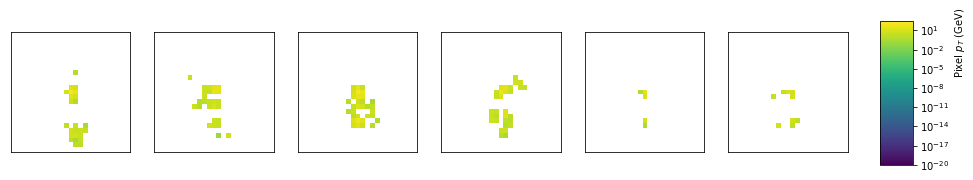

In [415]:
# plot random images from the GAN-generated dataset
plot_random_jetimages(fake_images)

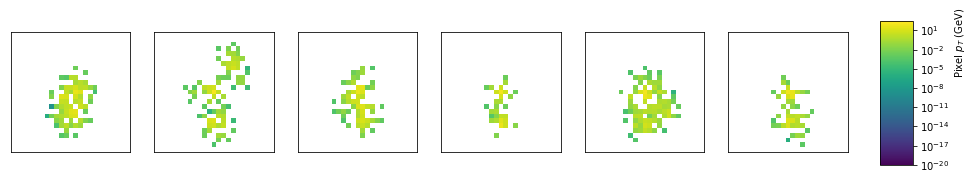

In [416]:
# compare them to random images from the training set
plot_random_jetimages(data_loader.dataset.images)

Calculate Euclidean distances between each pair of images in each dataset:

In [196]:
def distances(images):
    d = []
    for i in images:
        for j in images:
            d.append(np.sum((i-j)**2))
    return d

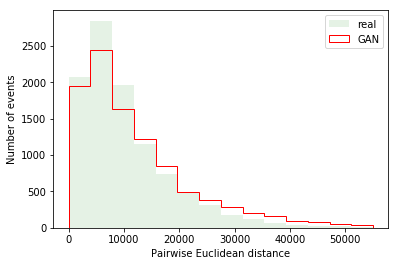

In [197]:
# plot the distances for the real and GAN-generated dataset
bins = np.linspace(0, 55000, 15)
_ = plt.hist(distances(data_loader.dataset.images[:batch_size]),
             bins=bins, histtype='stepfilled', label='real', color='green', alpha=0.1)
_ = plt.hist(distances(fake_images), bins=bins, histtype='step', label='GAN', color='red')
plt.legend()
plt.xlabel('Pairwise Euclidean distance')
plt.ylabel('Number of events')

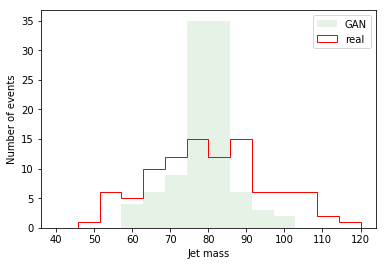

In [198]:
bins = np.linspace(40, 120, 15)
_ = plt.hist(discrete_mass(data_loader.dataset.images[:batch_size]),
             histtype='stepfilled', bins=bins, label='GAN', color='green', alpha=0.1)
_ = plt.hist(discrete_mass(fake_images), histtype='step', bins=bins, label='real', color='red')
plt.legend()
plt.xlabel('Jet mass')
plt.ylabel('Number of events')

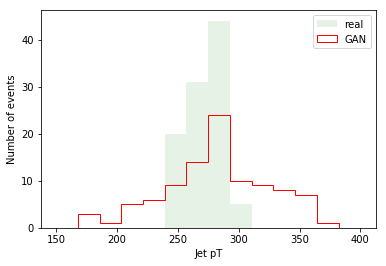

In [199]:
bins = np.linspace(150, 400, 15)
_ = plt.hist(discrete_pt(data_loader.dataset.images[:batch_size]),
             histtype='stepfilled', bins=bins, label='real', color='green', alpha=0.1)
_ = plt.hist(discrete_pt(fake_images), histtype='step', bins=bins, label='GAN', color='red')
plt.legend()
plt.xlabel('Jet pT')
plt.ylabel('Number of events')

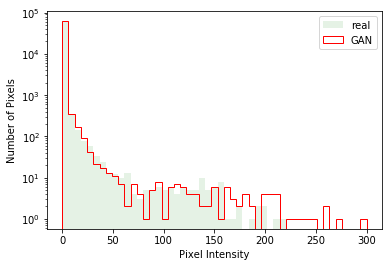

In [200]:
bins=np.linspace(0, 300, 50)
_ = plt.hist(data_loader.dataset.images[:batch_size].ravel(),
             bins=bins, histtype='stepfilled', color='green', alpha=0.1, label='real')
_ = plt.hist(fake_images.ravel(), bins=bins, histtype='step', color='red', label='GAN')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend()

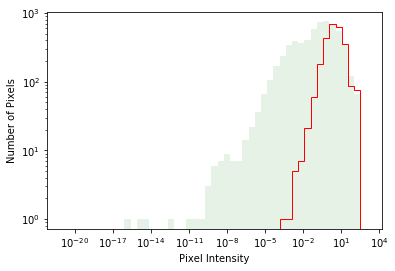

In [201]:
bins=np.logspace(-21, 3, 50)
_ = plt.hist(data_loader.dataset.images[:batch_size].ravel(),
             bins=bins, histtype='stepfilled', color='green', alpha=0.1, label='real')
_ = plt.hist(fake_images.ravel(), bins=bins, histtype='step', color='red', label='GAN')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.xscale('log')

We can go back up and see if things change after different epochs.

----

We can also look at the evolution of images over the epochs:

Epoch 001


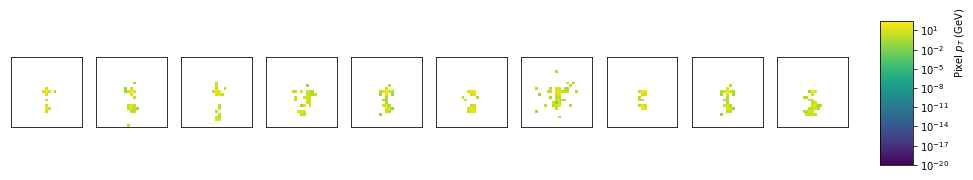

Epoch 002


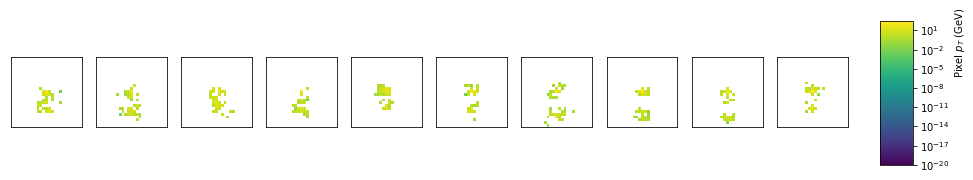

Epoch 003


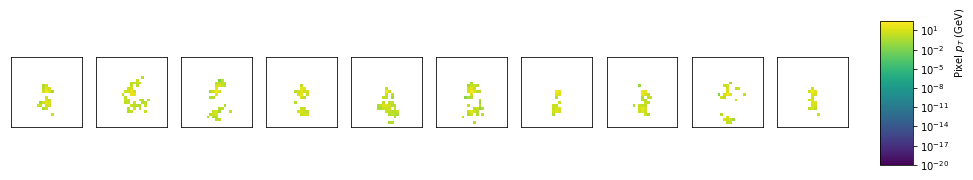

Epoch 004


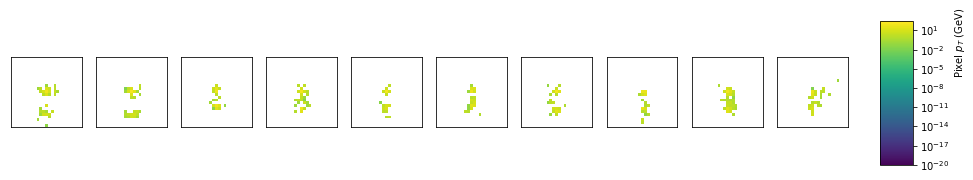

Epoch 005


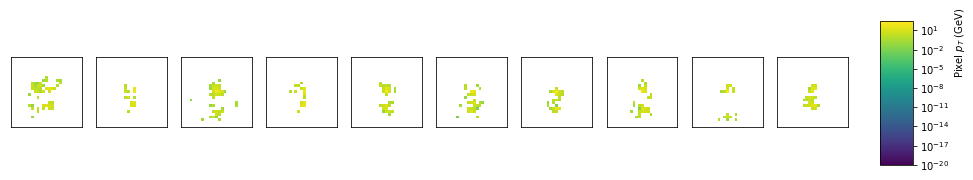

Epoch 006


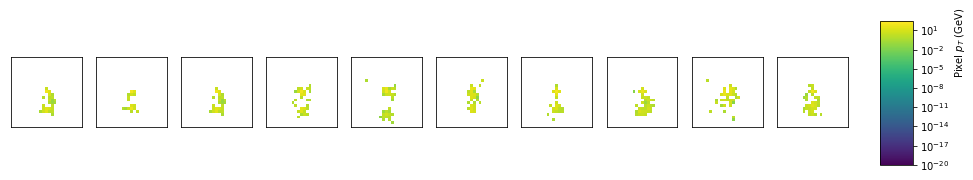

Epoch 007


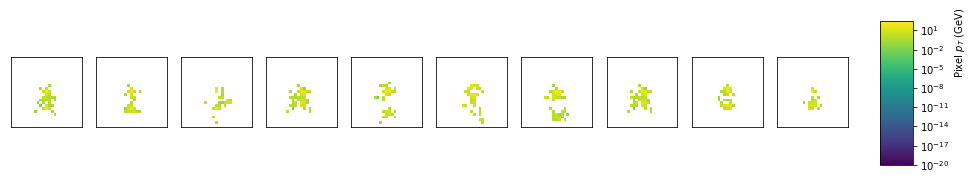

Epoch 008


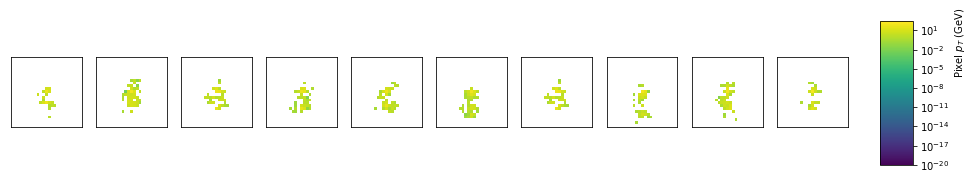

Epoch 009


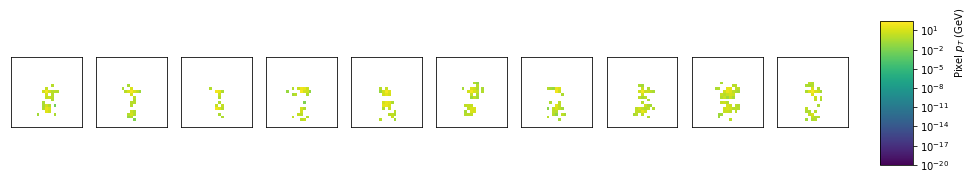

Epoch 010


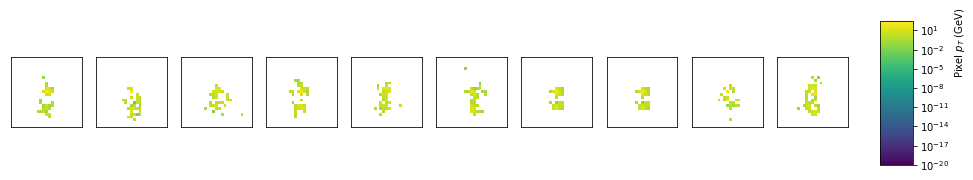

Epoch 011


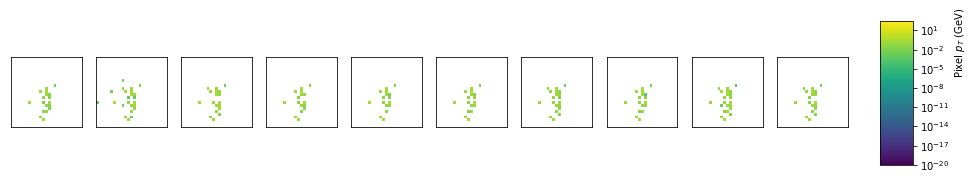

Epoch 012


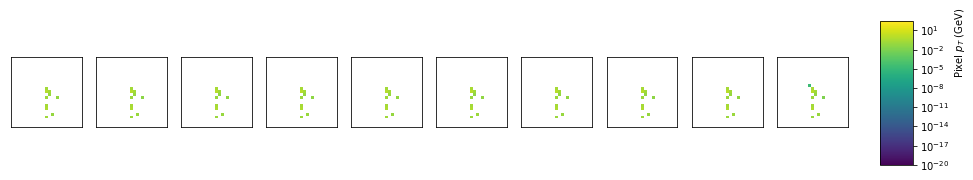

Epoch 013


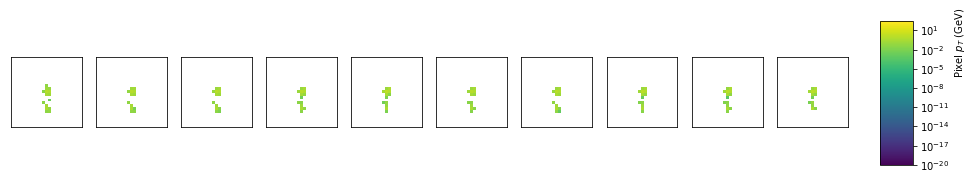

Epoch 014


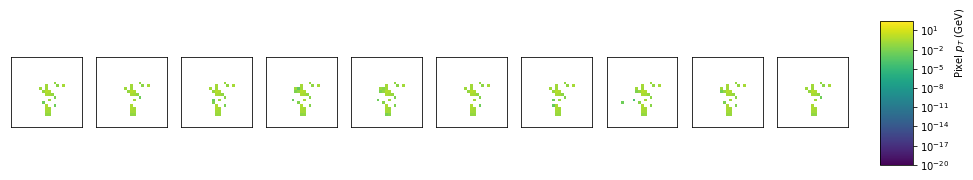

Epoch 015


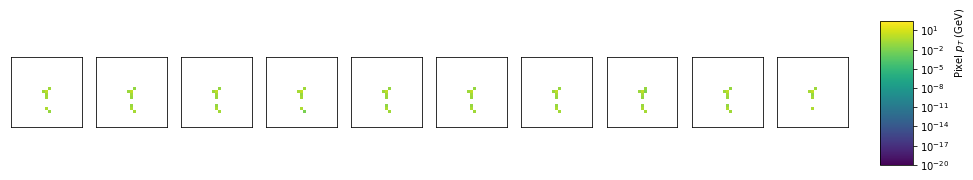

Epoch 016


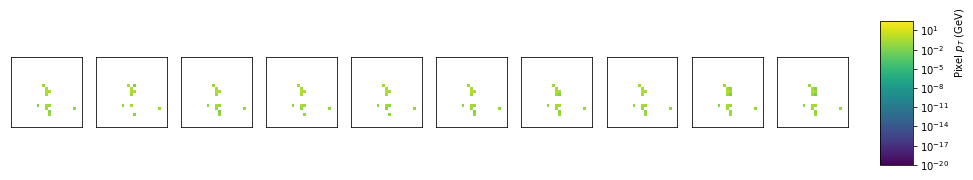

Epoch 017


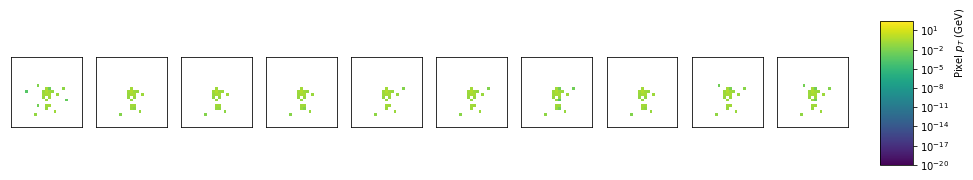

Epoch 018


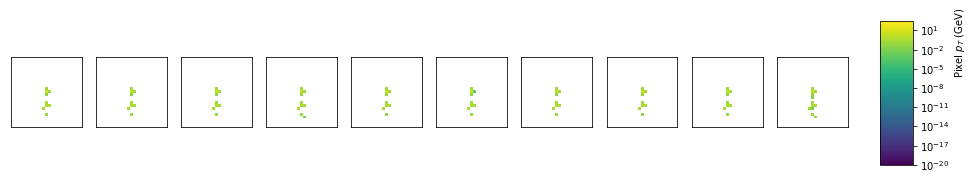

Epoch 019


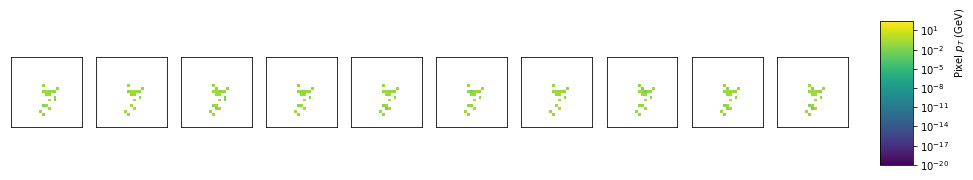

Epoch 020


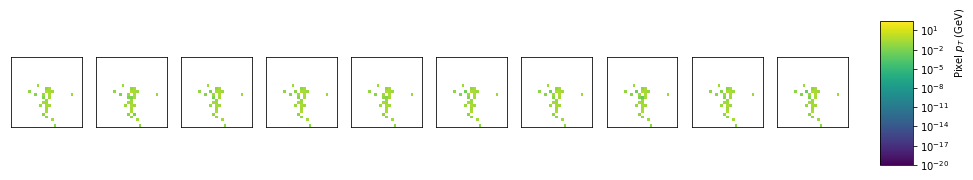

Epoch final


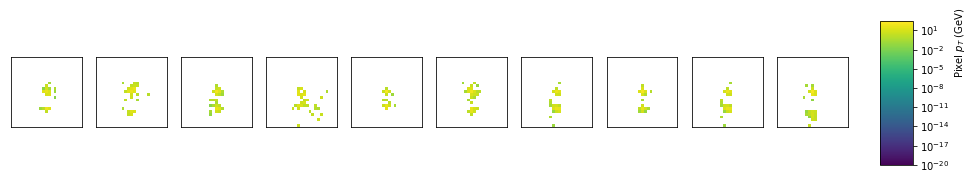

In [494]:
import glob
for _w in glob.glob('./weights/generator-*'):
    print('Epoch ' + _w.split('-')[-1].split('.')[0])
    
    # load weights into G
    G.load_state_dict(torch.load(_w))
    
    # produce a batch of fake images
    batch_size = 100
    z = to_var(torch.randn(batch_size, 64))
    fake_images = G(z).data.numpy().reshape(-1, 25, 25)
    
    # plot a few of them
    plot_random_jetimages(fake_images, njets=10)
    plt.show()

There is certainly evidence of mode collapse in this specific instance of the training after a few epochs.

### Wasserstein GANs

A recently proposed solution to the general instability of GANs is the Wasserstein GAN, or WGAN. It addresses the issues with non-overlapping supports.

In lieu of the non-saturating heuristic that Vanilla GANs optimize, 

$$
\mathbb{E}_{x\sim p_{\mathsf{data}}(x)}[\log D(x;\theta_D)] + \mathbb{E}_{z\sim p_{z}(z)}[\log (1 - D(G(x;\theta_G);\theta_D))]
$$

WGANs propose to directly minimize the Wasserstein distance (or Earth Movers distance) between fake and real data.

Determining the Wasserstein distance between two distributions, $W(p,q)$, can be efficiently computed using the Kantorovich Rubenstein duality, allowing for minibatch sampled expectatins from $p$ and $q$. 

$$
K \cdot W(p,q)=\sup_{f : \Vert f\Vert_{L \leq K}} (\mathbb{E}_{x \sim P_r}[f(x)] - \mathbb{E}_{x \sim P_g}[f(x)])
$$

The "discriminator" from a normal GAN now becomes this $f$ here, and the parameters of $f$ are clamped to make it's weights compact, and this the overal neural network $K$-Lipschitz. 

In practice, WGANs aim to maximize

$$
\mathbb{E}_{x \sim p_{\mathsf{data}}(x)}[f(x)] - \mathbb{E}_{\hat{x} \sim p_{\mathsf{model}}(\hat{x};\theta)}[f(\hat{x})]
$$

Implementing this in PyTorch is quite simple - we will change parlance from "discriminator" to "critic".


In [317]:
# Critic
# Note that we just have a linear output here
critic = nn.Sequential(
    nn.Linear(25 * 25, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1)
)

# Generator 
generator = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 25 * 25),
    nn.ReLU()
)

# if you're running on GPU, move models there
if torch.cuda.is_available():
    critic.cuda()
    generator.cuda()

In [318]:
# These are the recommended defaults (sauf N_EPOCHS) from the WGAN paper.
LR = 0.0005
N_EPOCHS = 20
N_CRITIC_STEPS = 5
CLAMP = 0.01

In [319]:
critic_optimizer = torch.optim.RMSprop(critic.parameters(), lr=LR)
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LR)

For the training loop, we want to alternate between `N_CRITIC_STEPS` critic updates and a single generator update. We'll keep a counter that will help us know where we are.

This is due to the fact that unlike normal GANs, we would like our critic to convervge before each generator update so that it's current estimate of the mutliplicatively scaled Wasserstein distance is more accurate and informative for the Generator.

In [320]:
# If you want to, you can keep track of the history of the training by saving all per-epoch losses
g_loss = []
c_loss = []

In [321]:
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        
        # Keep track of what critic step we're on
        crit_steps = 0
        
        # Keep track of the per-epoch losses
        epoch_g_loss = 0
        epoch_c_loss = 0
        
        # loop through batches (no need for class labels right now)
        for batch_number, (images, _) in enumerate(data_loader): 
            
            # this specific batch size (last one may not be equal to BATCH_SIZE)
            batch_size = images.shape[0] 
            
            # Reshape training dataset images from (batch_size, 25, 25) to (batch_size, 25*25) for 
            # processing through fully-connected net 
            images = to_var(images.view(batch_size, -1))

            # 1) TRAIN CRITIC
            # If we haven't done enough steps, let's train the critic
            if crit_steps < N_CRITIC_STEPS:
                critic.zero_grad()
                generator.zero_grad()
        
                # clamp parameters to a cube
                for p in critic.parameters():
                    p.data.clamp_(-CLAMP, CLAMP)

                # Accum predictions with real images (we want the critic to output a high value here)
                pred_real = torch.mean(critic(images))
            
                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum predictions for fake images (we want the critic to output a low value here)
                pred_fake = torch.mean(critic(fake_images)) 
                
                # If we minimize this, we maximize pred_real - pred_fake
                critic_loss = pred_fake - pred_real
                critic_loss.backward()
                critic_optimizer.step()
                
                # We increment our counter now that we've seen a critic update
                # If we still haven't done sufficient critic updates, we'll end up here again
                crit_steps += 1
                
            # 2) TRAIN GENERATOR
            # Here we have done N_CRITIC_STEPS critic updates, so we do the generator now
            else:
                critic.zero_grad()
                generator.zero_grad()

                # Draw random 64-dimensional noise vectors as inputs to the generator network
                z = to_var(torch.randn(batch_size, 64))
                
                # Transform the noise through the generator network to get synthetic images
                fake_images = generator(z)
                
                # Accum grads with fake images (generator wants the critic to 
                # output a high value here, "tricking" it)
                outputs = critic(fake_images)
                
                # We minimize this so we maximize the quantity we actually care about
                generator_loss = -torch.mean(outputs)

                # Backprop + Optimize the generator
                generator_loss.backward()
                generator_optimizer.step()
                
                # Reset the counter - the next batch will go to the critic!
                crit_steps = 0

                if (batch_number + 1) % 300 == 0:
                    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                          'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                          %(epoch,
                            N_EPOCHS,
                            batch_number + 1,
                            n_batches,
                            critic_loss.data[0],
                            generator_loss.data[0],
                            pred_real.data.mean(),
                            pred_fake.data.mean())
                    )
                    
                # Keep track of the per-epoch losses
                epoch_g_loss += generator_loss.data[0]
                epoch_c_loss += critic_loss.data[0]
                 
        g_loss.append(epoch_g_loss)
        c_loss.append(epoch_c_loss)
        
        # Save the trained parameters 
        torch.save(generator.state_dict(), './weights/wgan_generator-%0.3d.pkl' %(epoch + 1))
        torch.save(critic.state_dict(), './weights/wgan_discriminator-%0.3d.pkl' %(epoch + 1))
        
except KeyboardInterrupt:
    print('Training ended early.')

Epoch [0/20], Step[300/8726], d_loss: -3.7239, g_loss: -2.7260, Mean D(x): 6.20, Mean D(G(z)): 2.47
Epoch [0/20], Step[600/8726], d_loss: -2.0668, g_loss: -0.9106, Mean D(x): -0.70, Mean D(G(z)): -2.77
Epoch [0/20], Step[900/8726], d_loss: -3.4252, g_loss: 0.5271, Mean D(x): 3.07, Mean D(G(z)): -0.36
Epoch [0/20], Step[1200/8726], d_loss: -4.1013, g_loss: 0.1144, Mean D(x): 4.76, Mean D(G(z)): 0.66
Epoch [0/20], Step[1500/8726], d_loss: -4.2233, g_loss: 1.7200, Mean D(x): 4.47, Mean D(G(z)): 0.25
Epoch [0/20], Step[1800/8726], d_loss: -3.7967, g_loss: -1.3661, Mean D(x): 3.58, Mean D(G(z)): -0.21
Epoch [0/20], Step[2100/8726], d_loss: -4.1264, g_loss: 0.3313, Mean D(x): 3.13, Mean D(G(z)): -0.99
Epoch [0/20], Step[2400/8726], d_loss: -3.5116, g_loss: -0.6166, Mean D(x): 4.54, Mean D(G(z)): 1.02
Epoch [0/20], Step[2700/8726], d_loss: -3.1929, g_loss: -2.0354, Mean D(x): 3.37, Mean D(G(z)): 0.18
Epoch [0/20], Step[3000/8726], d_loss: -2.9032, g_loss: 1.4251, Mean D(x): 3.37, Mean D(G(z))

Now we can take a look at how we did.

(0, 20)

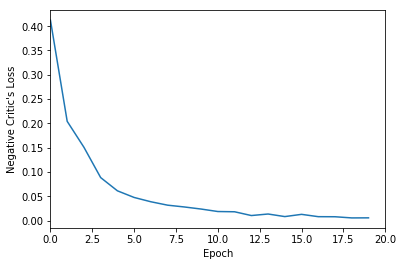

In [325]:
# Plot the history of the (scaled) Wasserstein distance
_ = plt.plot([-l/n_batches for l in c_loss])
plt.xlabel('Epoch')
plt.ylabel("Negative Critic's Loss")
plt.xlim(0, 20)

Epoch 001


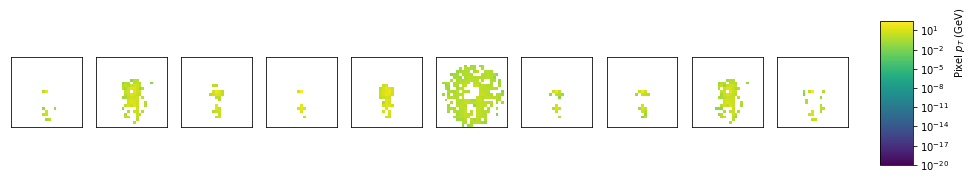

Epoch 002


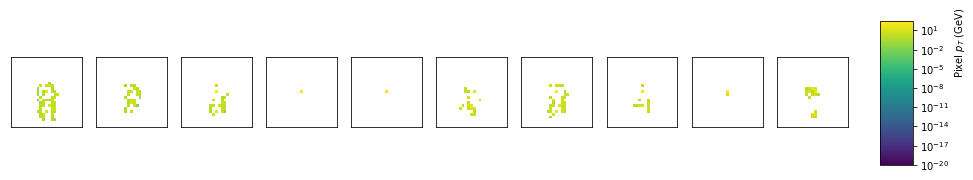

Epoch 003


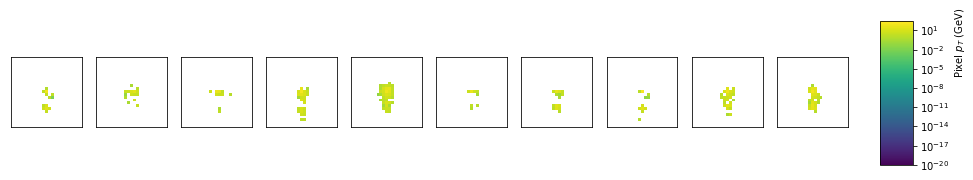

Epoch 004


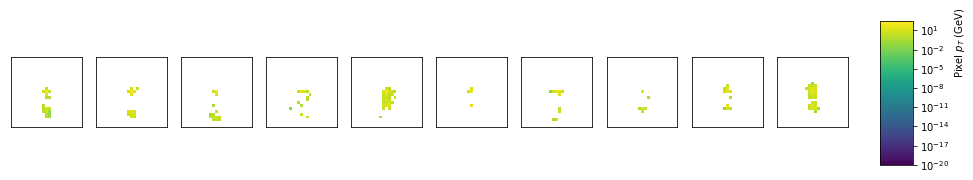

Epoch 005


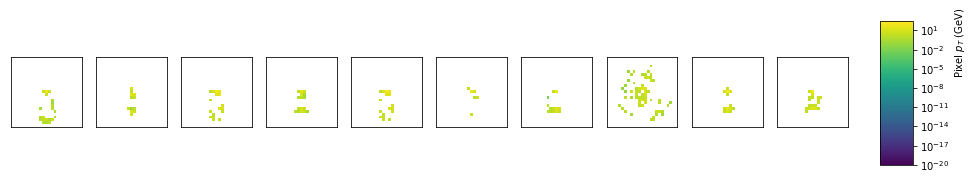

Epoch 006


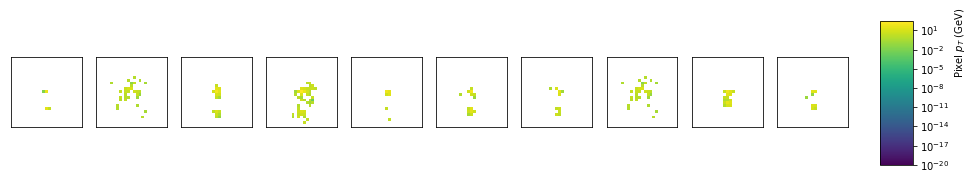

Epoch 007


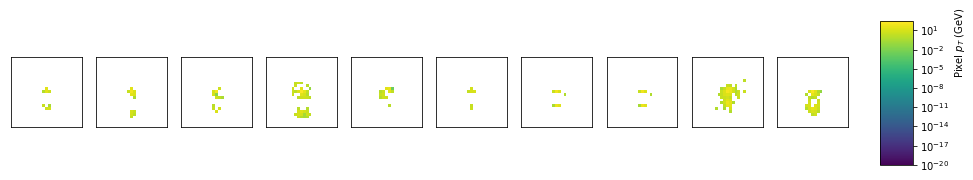

Epoch 008


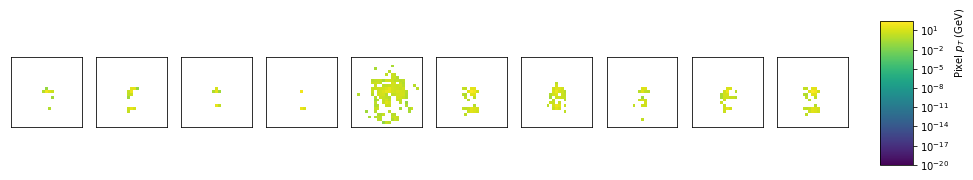

Epoch 009


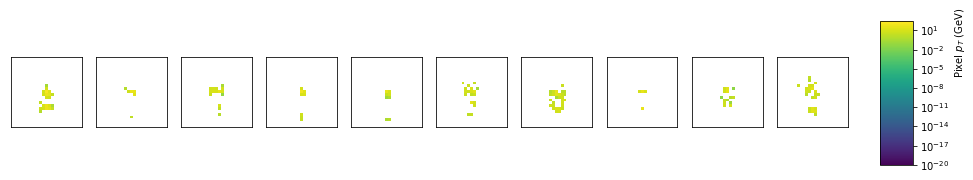

Epoch 010


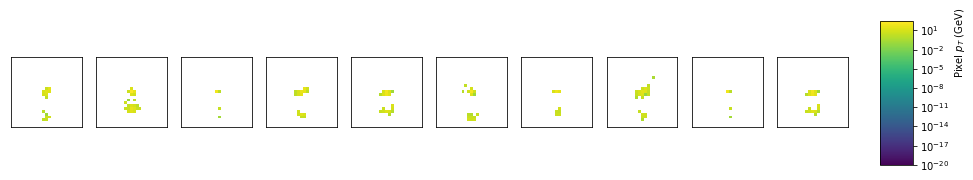

Epoch 011


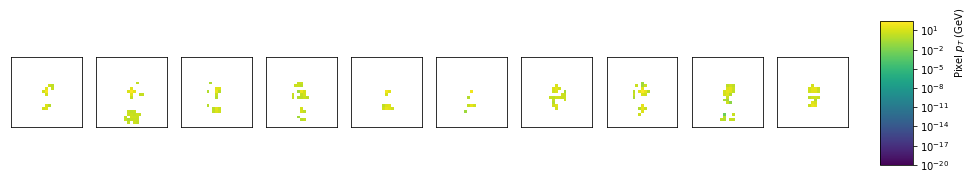

Epoch 012


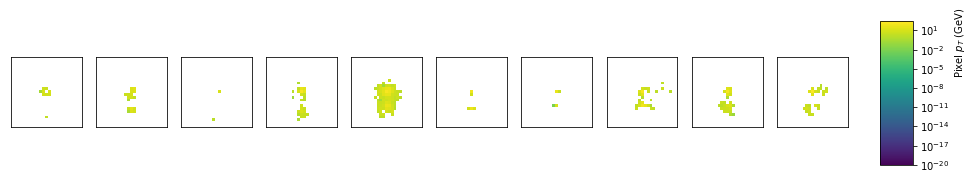

Epoch 013


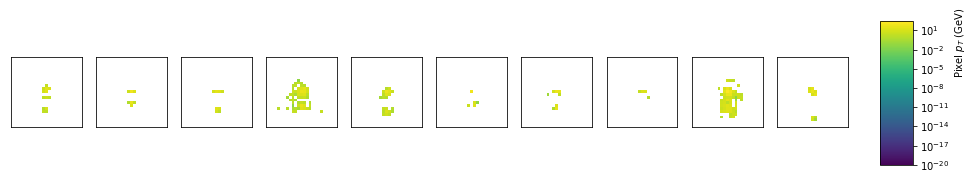

Epoch 014


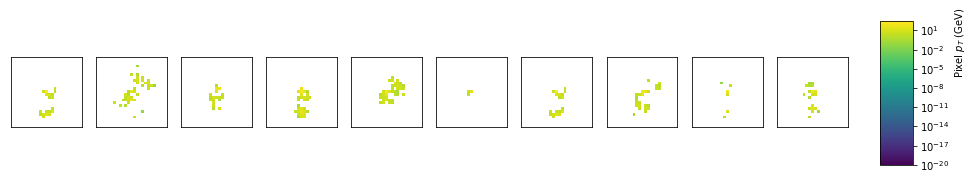

Epoch 015


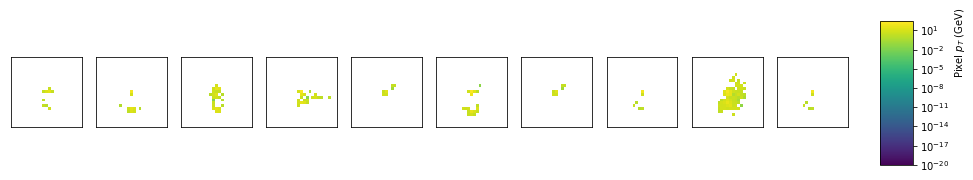

Epoch 016


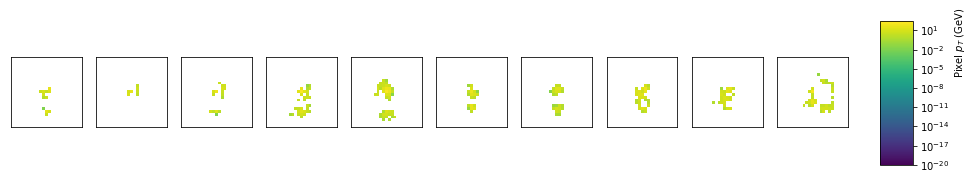

Epoch 017


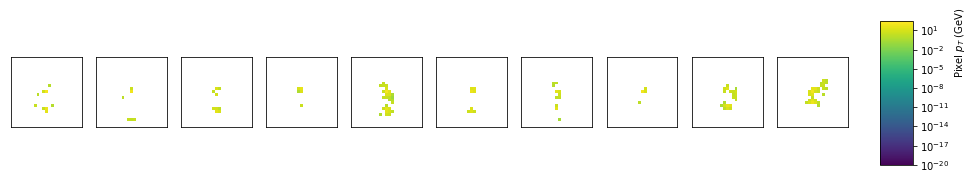

Epoch 018


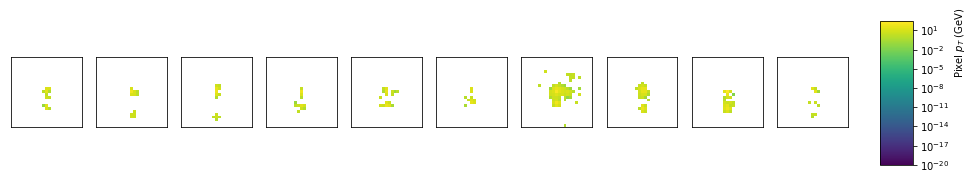

Epoch 019


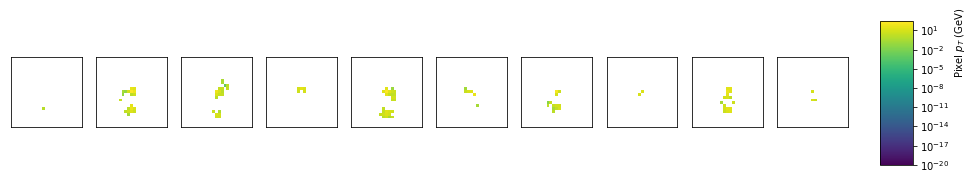

Epoch 020


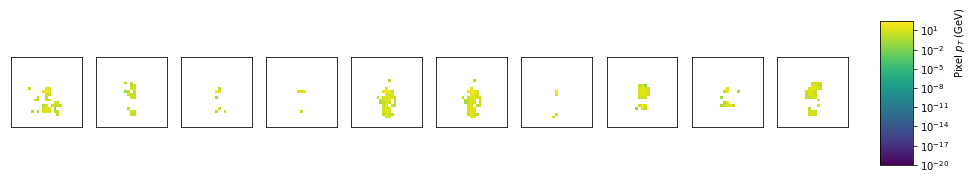

Epoch final


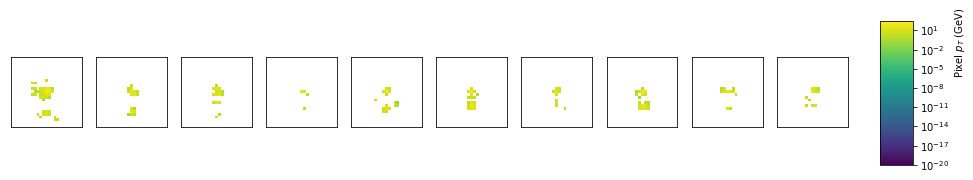

In [448]:
# Visual inspection 
for _w in glob.glob('./weights/wgan_generator-*'):
    print('Epoch ' + _w.split('-')[-1].split('.')[0])
    
    # load weights into G
    generator.load_state_dict(torch.load(_w))
    
    # produce a batch of fake images
    batch_size = 100
    z = to_var(torch.randn(batch_size, 64))
    fake_images = generator(z).data.numpy().reshape(-1, 25, 25)
    
    # plot a few of them
    plot_random_jetimages(fake_images, njets=10)
    plt.show()

Let's investigate the performance further at a given epoch.

In [483]:
# load in a different epoch if you want
generator.load_state_dict(torch.load('weights/wgan_generator-016.pkl'))

In [484]:
batch_size = 100
z = to_var(torch.randn(batch_size, 64)) # sample noise
fake_images = generator(z).data # pass it thru the generator to produce images

# move to cpu if running on gpu
if torch.cuda.is_available():
    fake_images = fake_images.cpu()
    
# reshape images from [batch_size, 625] to [batch_size, 25, 25]
fake_images = fake_images.numpy().reshape(-1, 25, 25)

In [485]:
# The previous training was done with the image intensity rescaling, so I'm scaling back now.
# fake_images = data_loader.dataset.inverse_image_transform(fake_images)

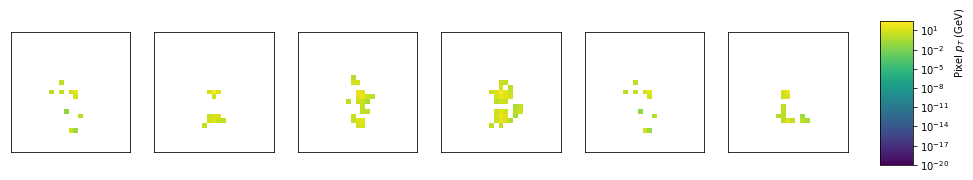

In [486]:
plot_random_jetimages(fake_images)

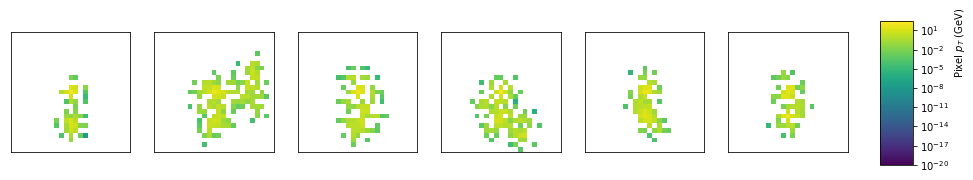

In [487]:
# compare to training dataset
plot_random_jetimages(data_loader.dataset.images)

Let's look at a few image properties.

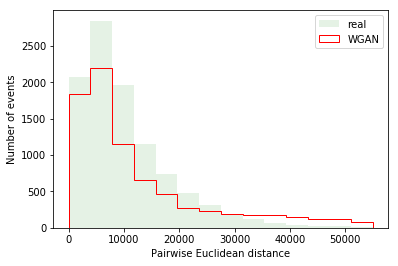

In [488]:
# plot the distances for the real and GAN-generated dataset
bins = np.linspace(0, 55000, 15)
_ = plt.hist(distances(data_loader.dataset.images[:batch_size]),
             bins=bins, histtype='stepfilled', label='real', color='green', alpha=0.1)
_ = plt.hist(distances(fake_images), bins=bins, histtype='step', label='WGAN', color='red')
plt.legend()
plt.xlabel('Pairwise Euclidean distance')
plt.ylabel('Number of events')

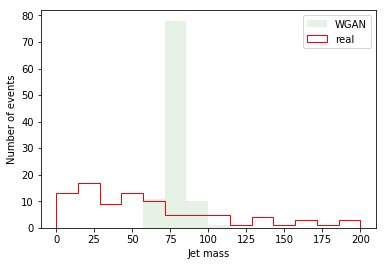

In [489]:
bins = np.linspace(0, 200, 15)
_ = plt.hist(discrete_mass(data_loader.dataset.images[:batch_size]),
             histtype='stepfilled', bins=bins, label='WGAN', color='green', alpha=0.1)
_ = plt.hist(discrete_mass(fake_images), histtype='step', bins=bins, label='real', color='red')
plt.legend()
plt.xlabel('Jet mass')
plt.ylabel('Number of events')

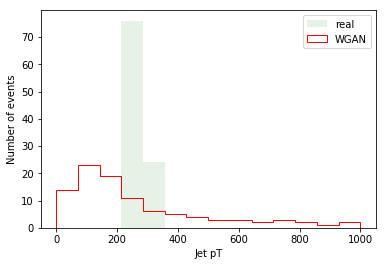

In [490]:
bins = np.linspace(0, 1000, 15)
_ = plt.hist(discrete_pt(data_loader.dataset.images[:batch_size]),
             histtype='stepfilled', bins=bins, label='real', color='green', alpha=0.1)
_ = plt.hist(discrete_pt(fake_images), histtype='step', bins=bins, label='WGAN', color='red')
plt.legend()
plt.xlabel('Jet pT')
plt.ylabel('Number of events')

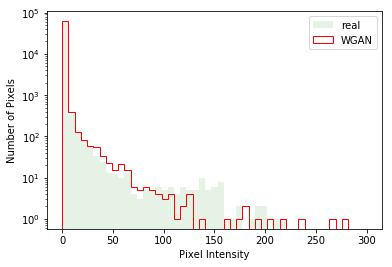

In [491]:
bins=np.linspace(0, 300, 50)
_ = plt.hist(data_loader.dataset.images[:batch_size].ravel(),
             bins=bins, histtype='stepfilled', color='green', alpha=0.1, label='real')
_ = plt.hist(fake_images.ravel(), bins=bins, histtype='step', color='red', label='WGAN')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.legend()

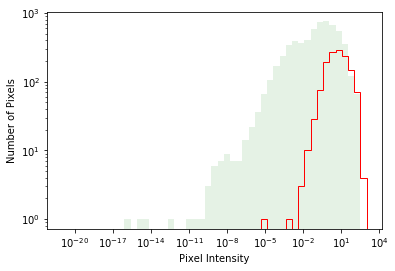

In [481]:
bins=np.logspace(-21, 3, 50)
_ = plt.hist(data_loader.dataset.images[:batch_size].ravel(),
             bins=bins, histtype='stepfilled', color='green', alpha=0.1, label='real')
_ = plt.hist(fake_images.ravel(), bins=bins, histtype='step', color='red', label='WGAN')

plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.yscale('log')
plt.xscale('log')

### Suggestions

Try Locally-Connected layers. While training our LAGAN model (https://arxiv.org/abs/1701.05927), we found them to perform best on jet-images, providing us with a useful compromise between convolutional and fully connected layers.

Not merged into PyTorch's master yet, but here's the code from the PR (I haven't tested it yet):
```python
class Conv2dLocal(Module):

    def __init__(self, in_height, in_width, in_channels, out_channels,
                 kernel_size, stride=1, padding=0, bias=True, dilation=1):
        # kernel_size = _pair(kernel_size)
        # stride = _pair(stride)
        # padding = _pair(padding)
        # dilation = _pair(dilation)
        # super(Conv2dLocal, self).__init__(
        #     in_channels, out_channels, kernel_size, stride, padding, dilation,
        #     False, _single(0), 1, bias)
        super(Conv2dLocal, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)

        self.in_height = in_height
        self.in_width = in_width
        self.out_height = int(math.floor(
            (in_height + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1) / self.stride[0] + 1))
        self.out_width = int(math.floor(
            (in_width + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1) / self.stride[1] + 1))
        self.weight = Parameter(torch.Tensor(
            self.out_height, self.out_width,
            out_channels, in_channels, *self.kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(
                out_channels, self.out_height, self.out_width))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d_local(input, self.weight, self.bias, stride=self.stride, padding=self.padding, dilation=self.dilation)
```

Our architecture for LAGAN looked like this.
<img src="lagan.png">
If you feel like re-implementing it in PyTorch, send us a PR!

2) Use Gradient Penalty (WGAN-GP) instead of weight clipping, as suggested in "Improved Training of Wasserstein GANs".
This snippet is adapted from https://github.com/caogang/wgan-gp

In [338]:
LAMBDA = 10 # Gradient penalty lambda hyperparameter

def calc_gradient_penalty(D, real_data, fake_data, batch_size):
    
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda() if torch.cuda.is_available() else alpha # for gpu

    # find new data points by interpolating between real and fake samples
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    if torch.cuda.is_available():
        interpolates = interpolates.cuda()  
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    predictions = D(interpolates)

    gradients = autograd.grad(
        outputs=predictions,
        inputs=interpolates,
        grad_outputs=torch.ones(predictions.size()).cuda() if torch.cuda.is_available()
                else torch.ones(predictions.size()),
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

Caluclate the GP while training your discriminator and add it to the D's loss:
```python
gradient_penalty = calc_gradient_penalty(critic, images.data, fake_images.data)
critic_loss = pred_fake - pred_real + gradient_penalty
```

### Tricks

In [210]:
def add_instance_noise(images, std=0.1):
    '''
    add normal noise to images
    '''
    noise = Variable(std * torch.randn(images.shape))
    return images + noise

In [ ]:
def label_flip(x, p=0.05):
    '''
    bit flip with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of flip
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    x_new[selection] = (x_new[selection].type(torch.ByteTensor)^1).type(torch.FloatTensor)
    return x_new

In [ ]:
def label_smoothe(x, p=0.05, smoothing_param=0.3):
    '''
    label smoothing with some probability
    Args:
    ----
        x = torch.FloatTensor
        p = float, probability of an entry being selected for smoothing
        smoothing_param = float, max amount of variation
    Returns:
    --------
        x_new = torch.FloatTensor
    '''
    x_new = x.clone()
    selection = torch.rand(x_new.shape) < prob
    smoothing = torch.rand(selection.sum()) * smoothing_param
    x_new[selection] = torch.abs(x_new[selection] - smoothing)
    return x_new

In [ ]:
# from t-ae (https://gist.github.com/t-ae/732f78671643de97bbe2c46519972491)
class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims, mean=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims
        self.mean = mean
        # trainable tensor T
        self.T = nn.Parameter(torch.Tensor(in_features, out_features, kernel_dims))
        init.normal(self.T, 0, 1)

    def forward(self, x):
        # x is NxA
        # T is AxBxC
        matrices = x.mm(self.T.view(self.in_features, -1)) # x * T
        matrices = matrices.view(-1, self.out_features, self.kernel_dims)

        M = matrices.unsqueeze(0)  # 1xNxBxC
        M_T = M.permute(1, 0, 2, 3)  # Nx1xBxC
        norm = torch.abs(M - M_T).sum(3)  # NxNxB
        expnorm = torch.exp(-norm)
        o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance
        if self.mean:
            o_b /= x.size(0) - 1

        x = torch.cat([x, o_b], 1)
        return x

In [ ]:
def feature_matching(hidden, batch_weights):
    '''
    Augment your hidden features with batch_level statistics.
    These can be used to help the discriminator classify real vs fake.
    Alternatively, you can use these features to add a term to the loss of the form:
    ||f(x_real) - f(x_fake)||^2
    
    If your events are weighted, make sure to use batch_weights to compute the correct mean and std.
    '''
    batch_mean = batch_weights.mm(hidden).expand(batch_size, hidden.shape[-1])
    batch_second_moment = batch_weights.mm(torch.pow(hidden, 2)).expand(batch_size, hidden.shape[-1])
    batch_std = batch_second_moment - torch.pow(batch_mean, 2)
    
    # concatenate all features
    all_features = torch.cat([batch_mean, batch_std, hidden], 1)
    return all_features

### Conclusions

We have seen that WGANs add some stability, but out of the box models cannot take us all the way. Other tricks in the literature have helped stabilize normal GANs as well. It is likely that you'll have to adopt some of thos tricks or come up with your own to make these models work on your specific application.

### Class Conditioning

There have been several proposed ways of effectively using labels to condition generation (and sometimes improve the training altogether). 
<img src="https://raw.githubusercontent.com/gitlimlab/ACGAN-PyTorch/master/figs/architecture.png">

Our DataLoader yields both images and labels for each batch. In this tutorial, we did not use class labels, but if you decide to use them for conditioning, simply relace 
```python
for batch_number, (images, _) in enumerate(data_loader):
```
with

```python
for batch_number, (images, labels) in enumerate(data_loader):
```

Then, make sure to modify either your Generator (C-GAN, InfoGAN, AC-GAN) to take in a class label/embedding in addition to the input noise, or your Discriminator (Semi-Supervised GAN, InfoGAN, AC-GAN) to make sure the output is consistent with their formulation.

For example, in AC-GAN: randomly sample labels to request to your Generator (or get the labels from the dataloader in the case of the real training dataset), then make sure the Discriminator can correctly classify the images according to their label (here W vs QCD). This would require adding a cross-entropy term to your losses that both G and D try to minimize.

### Other Resources and Examples

* PyTorch DCGAN (Deep Convolutional GAN): https://github.com/pytorch/examples/tree/master/dcgan
* PyTorch VAE (Variational Auto-Encoder): https://github.com/pytorch/examples/tree/master/vae
* "How to Train a GAN? Tips and tricks to make GANs work": https://github.com/soumith/ganhacks